In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import optuna

/Users/sudevchirappat/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_abs = pd.read_csv('Data/labelled_vector_50000cross301.csv',index_col=0)
df_nor = pd.read_csv('Data/final_unit_vector.csv')
df_awt = pd.read_csv('Data/vector_with_text.csv')

In [75]:
def setup_data_for_training(df,drop_cols = ['label']):
    # get the labels
    y = pd.factorize(df.label.values)[0]
    y_label_map =  pd.factorize(df.label.values)[1]
    x = df.drop(drop_cols, axis=1)

    #
    # Create training and validation sets
    #

    # x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    return train_data,val_data,test_data,y_label_map

In [76]:
train_data,val_data,test_data,y_label_map = setup_data_for_training(df_awt,['label','text'])

In [77]:
test_data.data.shape

(10000, 300)

In [78]:
#
# Train the model
#
parameters = {
          "objective" : "multiclass",
          "num_class" : 5,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

In [106]:
%%time
model = lgb.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[1]	valid_0's multi_logloss: 1.55057
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.49984
[3]	valid_0's multi_logloss: 1.45621
[4]	valid_0's multi_logloss: 1.41838
[5]	valid_0's multi_logloss: 1.38479
[6]	valid_0's multi_logloss: 1.35563
[7]	valid_0's multi_logloss: 1.32894
[8]	valid_0's multi_logloss: 1.30496
[9]	valid_0's multi_logloss: 1.28385
[10]	valid_0's multi_logloss: 1.2647
[11]	valid_0's multi_logloss: 1.24772
[12]	valid_0's multi_logloss: 1.232
[13]	valid_0's multi_logloss: 1.21776
[14]	valid_0's multi_logloss: 1.20438
[15]	valid_0's multi_logloss: 1.19215
[16]	valid_0's multi_logloss: 1.1816
[17]	valid_0's multi_logloss: 1.17083
[18]	valid_0's multi_logloss: 1.16143
[19]	valid_0's multi_logloss: 1.15296
[20]	valid_0's multi_logloss: 1.14459
[21]	valid_0's multi_logloss: 1.1366
[22]	valid_0's multi_logloss: 1.12958
[23]	valid_0's multi_logloss: 1.12302
[24]	valid_0's multi_logloss: 1.11683
[25]	valid_0's multi_logloss: 1.11109
[2

In [154]:
# model.save_model('assets/models/lgb_model_'+.txt')

In [155]:
# print('Loading model to predict...')
# # load model to predict
# model = lgb.Booster(model_file='model.txt')

In [116]:
%%time
y_pred = model.predict(test_data.data)

CPU times: user 1.56 s, sys: 34.6 ms, total: 1.6 s
Wall time: 246 ms


In [117]:
max_p_index = np.argmax(y_pred,axis=1)

In [120]:
(max_p_index == test_data.label).mean()

0.5952

In [121]:
y_pred_df = pd.DataFrame(y_pred,columns=y_label_map)

In [122]:
y_pred_df.head()

,Sports,Politics,Entertainment,Finance,Tech
0,0.073955,0.040285,0.700646,0.108104,0.077010
1,0.024659,0.047996,0.078077,0.772325,0.076942
2,0.100338,0.034416,0.155874,0.495111,0.214262
3,0.349881,0.586545,0.011524,0.033140,0.018909
4,0.080255,0.109564,0.056289,0.224003,0.529889


In [123]:
t = test_data.data.copy()

In [124]:
t['text'] = df_awt[df_awt.index.isin(t.index)]['text']

In [125]:
t.reset_index(drop=True, inplace=True)
y_pred_df.reset_index(drop=True, inplace=True)

In [128]:
pred_df = pd.concat([t,y_pred_df],axis=1)

In [129]:
pred_df['max_p_label'] = y_label_map[max_p_index]

In [130]:
pred_df['original_label'] = y_label_map[test_data.label]

In [131]:
from sklearn.metrics import confusion_matrix

In [132]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 870  598  379  132  107]
 [ 121 1389  150  180  161]
 [ 183   86 1274  214  194]
 [  58   48  194 1273  410]
 [  49  101  269  414 1146]]


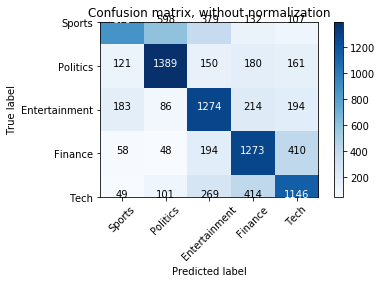

In [133]:
cnf_matrix = confusion_matrix(pred_df['original_label'], pred_df['max_p_label'],labels=y_label_map)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y_label_map,title='Confusion matrix, without normalization')

In [165]:
from bs4 import BeautifulSoup
import os
from multiprocessing import Pool
import glob
TG_DATA = "./Data/TG_Data"

In [166]:
def read_filelist(folder_path = "."):
    r_path = os.path.join(folder_path, "**/*.html")
    file_list = [f for f in glob.glob(r_path, recursive=True)]
    return file_list

In [167]:
%%time
file_list = read_filelist(TG_DATA)

CPU times: user 2.14 s, sys: 2.48 s, total: 4.62 s
Wall time: 10.7 s


In [168]:
def get_soup(file):
    with open(file,'r') as file_ptr:
        soup = BeautifulSoup(file_ptr,'lxml')
    return soup

In [169]:
def extract_text(soup,tag = 'all'):
    assert tag in ['all','p','h1']
    if tag == 'all':
        text = soup.text.strip()
    else:
        p_contents = soup.find_all(tag)
        text = ""
        for p in p_contents:
            text = text + p.getText()
    return text

In [171]:
def parse_html_file(file):
    soup = get_soup(file)
    d = extract_meta(soup)
    d['p_text'] = extract_text(soup,'p')
    return d

In [170]:
%%time
def load_vectors(fname): 
    import io
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return n,d,data

n,d,ft_dict = load_vectors("assets/wiki-news-300d-1M.vec")

CPU times: user 1min 8s, sys: 31.9 s, total: 1min 40s
Wall time: 1min 54s


In [188]:
def get_ft_vec(token,ft_dict,d=300):
    try:
        v = np.array(ft_dict[token])
    except KeyError:
        v = np.array([0]*d)
    return v

def compute_ft_sum(textlist,ft_dict,d=300):
    ret_vec = np.array([0]*d)
    for key in textlist:
        vec = get_ft_vec(key,ft_dict)
        # Vector addition of token embeddings
        ret_vec = ret_vec + vec
    return list(ret_vec)

def compute_doc_ft(fname,ft_dict):
    parse_html_file(fname)
    # Read html text
    import text_preprocessing as tp
    arr = tp.preprocess(doc_text)
    vector = compute_ft_sum(arr, ft_dict)
    return vector

In [ ]:
%%time
pool = Pool()
results= pool.map(parse_html_file, file_list)
pool.close()

In [ ]:
try:
    pool = Pool()
    pool.map(yourfunction, arguments)
finally:
    pool.close()
    pool.join()

In [ ]:
%%time
pool = Pool()
results= pool.map(detect_langage, list(df_headline['text']))
pool.close()